In [1]:
import importlib
from libs import trades, plots, params
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)

display(HTML("""
<style>
.output_scroll {
    overflow-y: visible !important;
    max-height: none !important;
}
</style>
"""))


/usr/bin/python


/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ticker = params.ticker
folder = "Intraday stocks" 

bidasktoclose_spread = 0.03

date_to_check = None
date_to_check = '2024-12' # if 'None' (just comment this line) all dates to be analyzed and final merged CSV to be saved

dfs training/GOOGL_base.csv already exists. Reading and plotting the processed data...


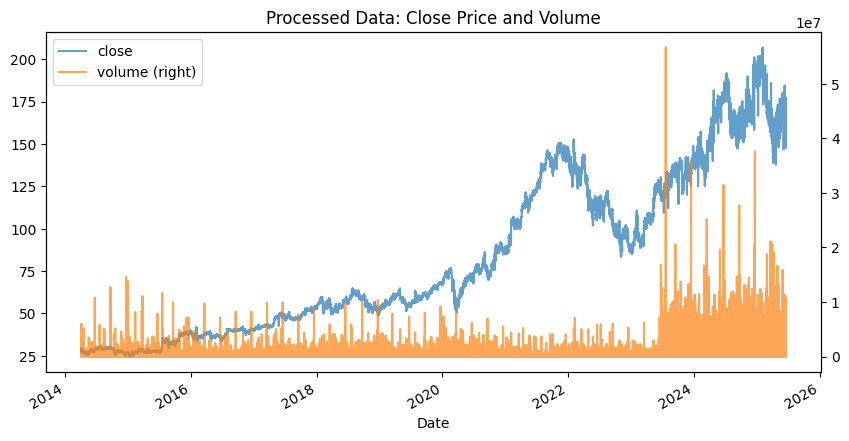

reference_gain 0.021259211873474328


open      high       low     close   volume  \
datetime                                                               
2014-04-03 10:42:00   28.6500   28.6500   28.6500   28.6500   2000.0   
2014-04-03 10:43:00   28.6500   28.6500   28.6500   28.6500   2000.0   
2014-04-03 11:04:00   28.6500   28.6500   28.6500   28.6500  11220.0   
2014-04-03 11:05:00   28.6500   28.6500   28.6500   28.6500   4620.0   
2014-04-03 11:34:00   28.5005   28.5005   28.5005   28.5005   3460.0   
...                       ...       ...       ...       ...      ...   
2025-06-18 23:55:00  173.9000  173.9445  173.8670  173.8681   3136.0   
2025-06-18 23:56:00  173.8200  173.9500  173.7900  173.9000    183.0   
2025-06-18 23:57:00  173.9500  173.9500  173.8600  173.8601    240.0   
2025-06-18 23:58:00  173.8600  173.9000  173.8600  173.8600    327.0   
2025-06-18 23:59:00  173.8700  173.8700  173.8600  173.8700    124.0   

                            ask         bid  
datetime                                     
2014-04-03 10:42:00   28.658595   28.641405  
2014-04-03 10:43:00   28.658595   28.641405  
2014-04-03 11:04:00   28.658595   28.641405  
2014-04-03 11:05:00   28.658595   28.641405  
2014-04-03 11:34:00   28.509050   28.491950  
...                         ...         ...  
2025-06-18 23:55:00  173.920300  173.815900  
2025-06-18 23:56:00  173.952200  173.847800  
2025-06-18 23:57:00  173.912300  173.807900  
2025-06-18 23:58:00  173.912200  173.807800  
2025-06-18 23:59:00  173.922200  173.817800  

[1462494 rows x 7 columns]

In [3]:
# first process of the dataframe, adding artificial bid and ask prices, and correcting possible price splits

df = trades.process_splits(folder=folder, 
                                ticker=ticker, 
                                bidasktoclose_spread=bidasktoclose_spread,
                                vol_fact=1)

reference_gain = trades.compute_reference_gain(df)

print('reference_gain', reference_gain)

df

In [4]:

def aggregate_performance(perf_list, round_digits=3):
    """
    Given a list of daily performance dictionaries, aggregate them as follows:
      - For numeric keys, sum their values and round the result.
      - For list keys (like "Trade Gains ($)" and "Trade Gains (%)"), replace them
        with a message indicating the number of trades.
    Then update:
      - "Strategy Profit Difference ($)" = "Final Net Value ($)" - "Buy & Hold Gain ($)"
      - "Strategy Improvement (%)"    = "Final Net Return (%)" - "Buy & Hold Return (%)"
    Returns the aggregated performance dictionary.
    """
    aggregated = {}
    keys = set()
    for perf in perf_list:
        if perf is not None:
            keys.update(perf.keys())
    for key in keys:
        if key in ["Trade Gains ($)", "Trade Gains (%)"]:
            temp_list = []
            for perf in perf_list:
                if perf and key in perf and isinstance(perf[key], list):
                    temp_list.extend(perf[key])
            aggregated[key] = f"{len(temp_list)} trades"
        else:
            total = 0
            for perf in perf_list:
                if perf and key in perf and isinstance(perf[key], (int, float)):
                    total += perf[key]
            aggregated[key] = round(total, round_digits)
    if "Final Net Value ($)" in aggregated and "Buy & Hold Gain ($)" in aggregated:
        aggregated["Strategy Profit Difference ($)"] = round(
            aggregated["Final Net Value ($)"] - aggregated["Buy & Hold Gain ($)"], round_digits)
    if "Final Net Return (%)" in aggregated and "Buy & Hold Return (%)" in aggregated:
        aggregated["Strategy Improvement (%)"] = round(
            aggregated["Final Net Return (%)"] - aggregated["Buy & Hold Return (%)"], round_digits)
    return aggregated



In [5]:

def saveDF_checkDAY(
    df,
    ticker,
    min_prof_thr,
    max_down_prop,
    gain_tightening_factor,
    smooth_win_sig,
    pre_entry_decay,
    buy_threshold,
    trailing_stop_thresh,
    merging_retracement_thr,
    merging_time_gap_thr,
    reference_gain,
    keep_cols=None,
    date_to_check=None
):
    """
    Modes:
      • Month ('YYYY-MM')   → process each day, then summary  
      • Day   ('YYYY-MM-DD')→ process that day only  
      • None  → full‐run: smooth ALL, pipeline, merge+interpolate w/ progress, save CSV  
    """
    if keep_cols is None:
        keep_cols = [
            "open","high","low","close","volume",
            "bid","ask","signal_action",
            "StrategyEarning","EarningDiff","signal_smooth"
        ]

    performance_list = []

    # -------------------------------------------------------------------------
    # Process exactly one calendar day
    # -------------------------------------------------------------------------
    def process_single_day(day_str):
        print(f"\n=== Processing trading day {day_str} ===")
        day_dt = pd.to_datetime(day_str)
        day_df = df.loc[df.index.normalize() == day_dt].copy()
        if day_df.empty:
            print(" no data; skipping.")
            return

        try:
            day_df_prep = trades.prepare_interpolate_data( 
                df=day_df,
                regular_start=params.regular_start,
                regular_end=params.regular_end
            )
        except ValueError as ve:
            if "window 0" in str(ve):
                print(" warning: smoothing window=0; skipping smoothing.")
            else:
                raise

        result = trades.run_trading_pipeline(day_df_prep, 
                                             col_signal='signal_smooth',
                                             col_action='signal_action',
                                             reference_gain=reference_gain, 
                                             day_to_check=day_str)
        if result is None:
            print(" no trades found; skipping.")
            return

        df_day, trades_day, perf_day = result
        plots.plot_trades(
            df=df_day,
            col_signal1='signal_scaled',
            col_signal2='signal_smooth',
            col_action='signal_action',
            trades=trades_day,
            buy_threshold=buy_threshold,
            performance_stats=perf_day
        )
        plt.show(block=False)
        plt.close()

        performance_list.append(perf_day)
        order = [
            "Final Net Value ($)", "Buy & Hold Gain ($)",
            "Strategy Profit Difference ($)", "Final Net Return (%)",
            "Buy & Hold Return (%)", "Strategy Improvement (%)",
            "Trade Gains ($)", "Trade Gains (%)"
        ]
        summary = OrderedDict()
        for key in order:
            if key in perf_day:
                val = perf_day[key]
                summary[key] = round(val, 3) if isinstance(val, (int, float)) else val

        print(" Daily Performance:")
        for k, v in summary.items():
            print(f"   {k}: {v}")

    # -------------------------------------------------------------------------
    # Main dispatch logic
    # -------------------------------------------------------------------------
    if date_to_check:
        # Month mode: 'YYYY-MM'
        if len(date_to_check) == 7:
            print(f"\nMonth mode: processing {date_to_check}")
            days = (
                df.loc[df.index.strftime("%Y-%m") == date_to_check]
                  .index.normalize()
                  .unique()
            )
            for d in sorted(days.astype(str)):
                process_single_day(d)

            monthly_summary = aggregate_performance(performance_list)
            print(f"\nFinal Summary for month {date_to_check}:")
            pprint(monthly_summary)
            return None

        # Single-day mode: 'YYYY-MM-DD'
        else:
            return process_single_day(date_to_check)

    print(f"\nFull-run mode: started at {datetime.now():%H:%M:%S}")
        
    print(" Step A: smoothing & DST adjust …")
    df_prep = trades.prepare_interpolate_data(
        df=df,
        regular_start=params.regular_start_shifted,
        regular_end=params.regular_end
    )
      
    print("\n Step B: running trading pipeline on full dataset …")
    full_sim_results = trades.run_trading_pipeline( 
        df_prep,
        col_signal='signal_smooth',
        col_action='signal_action',
        reference_gain=reference_gain,
        day_to_check=None
    )

    print("\n Step C: merging & concatenating all days …")
    daily_frames = [res[0][keep_cols] for res in full_sim_results.values()]
    merged = pd.concat(daily_frames).sort_index()
    
    print("\n Step D: saving CSV …")
    out_path = f"dfs training/{ticker}_final.csv"
    merged.to_csv(out_path)
    print(f"Saved to {out_path} at {datetime.now():%H:%M:%S}")

    return merged




Month mode: processing 2024-12

=== Processing trading day 2024-12-02 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


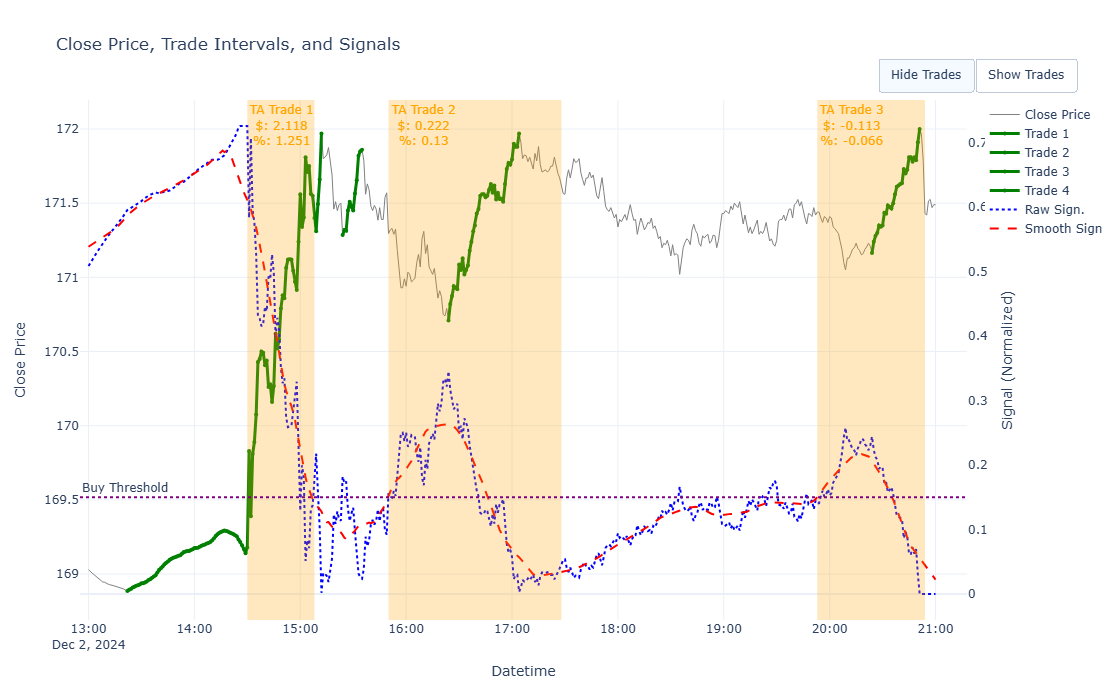

 Daily Performance:
   Final Net Value ($): 2.227
   Buy & Hold Gain ($): 2.208
   Strategy Profit Difference ($): 0.019
   Final Net Return (%): 1.316
   Buy & Hold Return (%): 1.305
   Strategy Improvement (%): 0.011
   Trade Gains ($): [2.118, 0.222, -0.113]
   Trade Gains (%): [1.251, 0.13, -0.066]

=== Processing trading day 2024-12-03 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


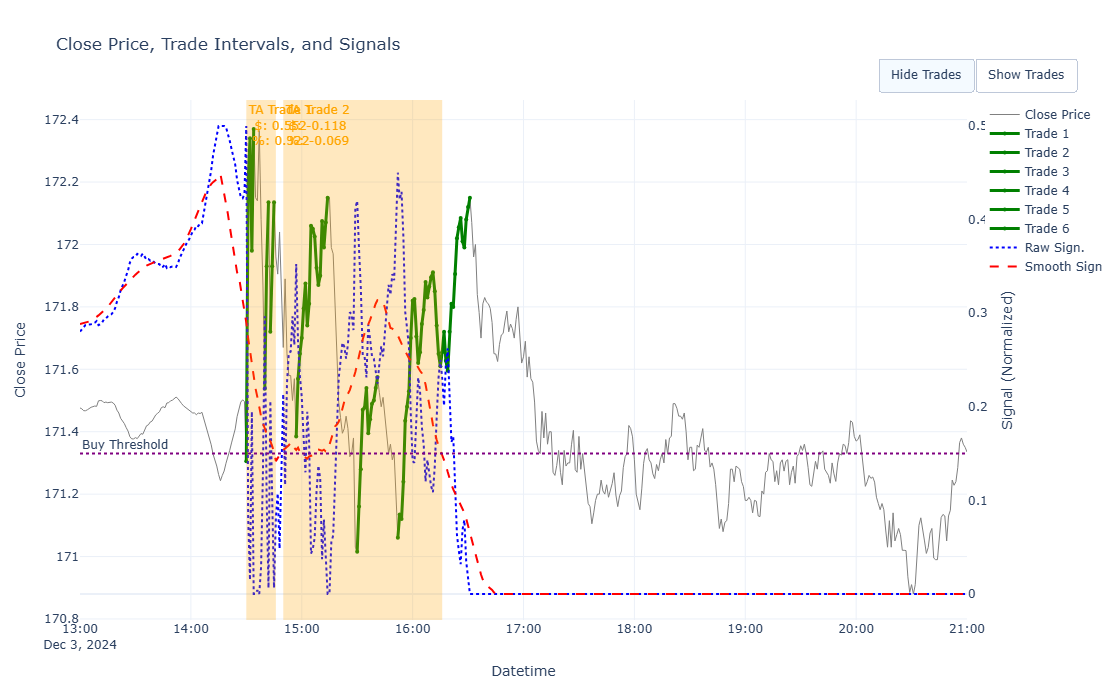

 Daily Performance:
   Final Net Value ($): 0.434
   Buy & Hold Gain ($): -0.058
   Strategy Profit Difference ($): 0.492
   Final Net Return (%): 0.253
   Buy & Hold Return (%): -0.034
   Strategy Improvement (%): 0.287
   Trade Gains ($): [0.552, -0.118]
   Trade Gains (%): [0.322, -0.069]

=== Processing trading day 2024-12-04 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


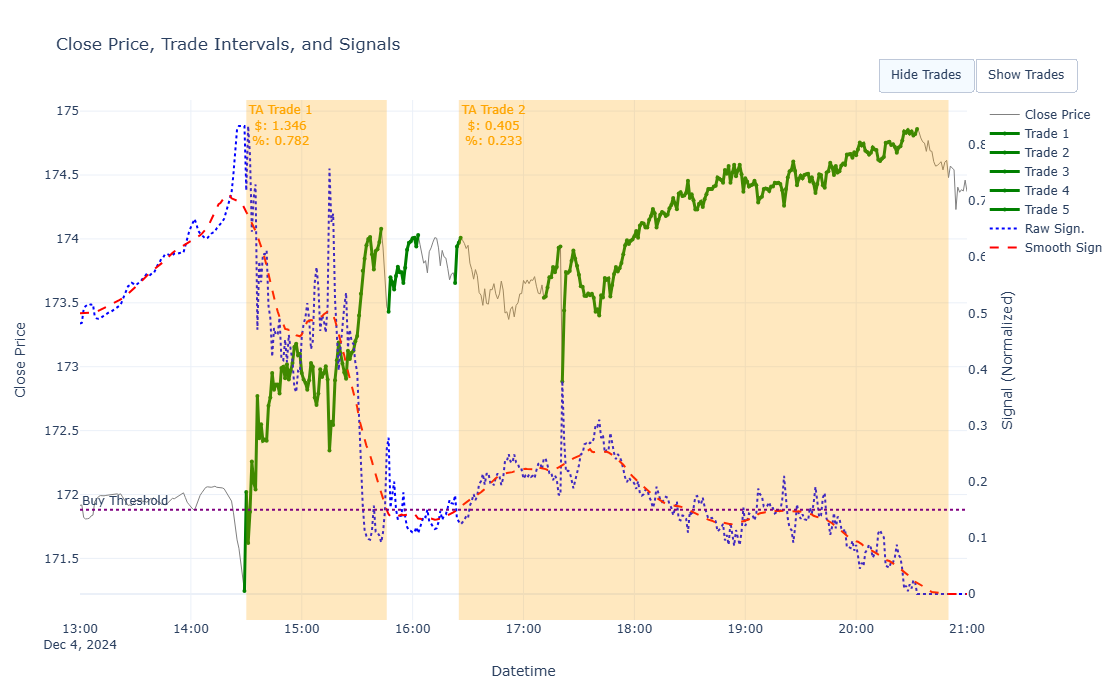

 Daily Performance:
   Final Net Value ($): 1.751
   Buy & Hold Gain ($): 2.336
   Strategy Profit Difference ($): -0.585
   Final Net Return (%): 1.018
   Buy & Hold Return (%): 1.358
   Strategy Improvement (%): -0.34
   Trade Gains ($): [1.346, 0.405]
   Trade Gains (%): [0.782, 0.233]

=== Processing trading day 2024-12-05 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


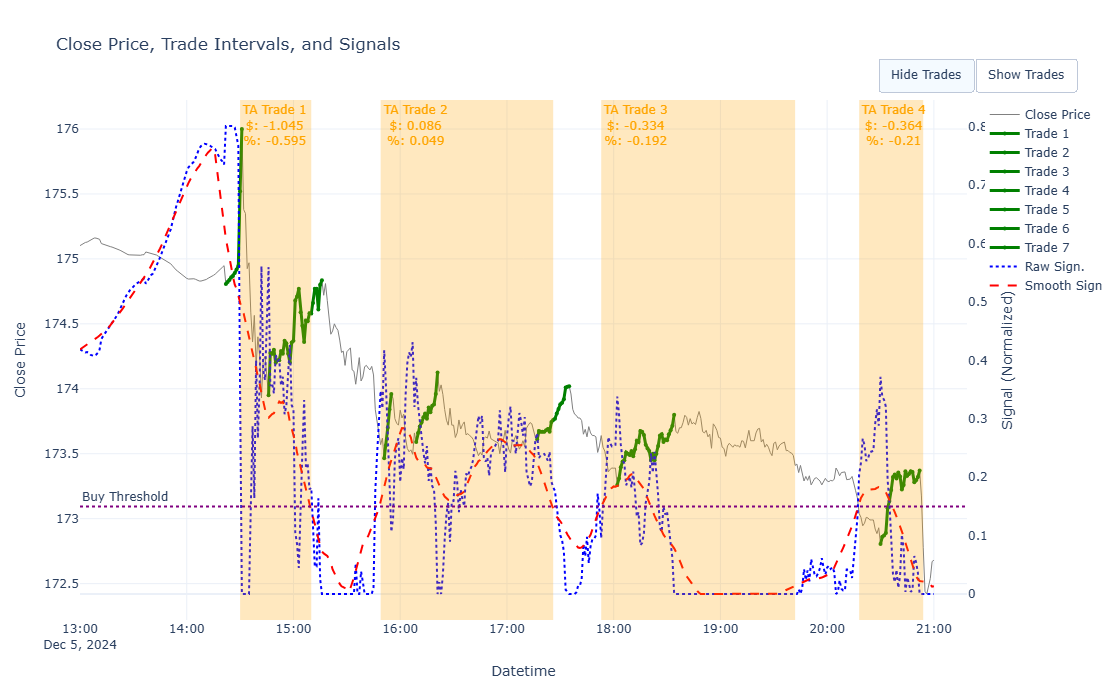

 Daily Performance:
   Final Net Value ($): -1.657
   Buy & Hold Gain ($): -2.954
   Strategy Profit Difference ($): 1.297
   Final Net Return (%): -0.944
   Buy & Hold Return (%): -1.683
   Strategy Improvement (%): 0.739
   Trade Gains ($): [-1.045, 0.086, -0.334, -0.364]
   Trade Gains (%): [-0.595, 0.049, -0.192, -0.21]

=== Processing trading day 2024-12-06 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


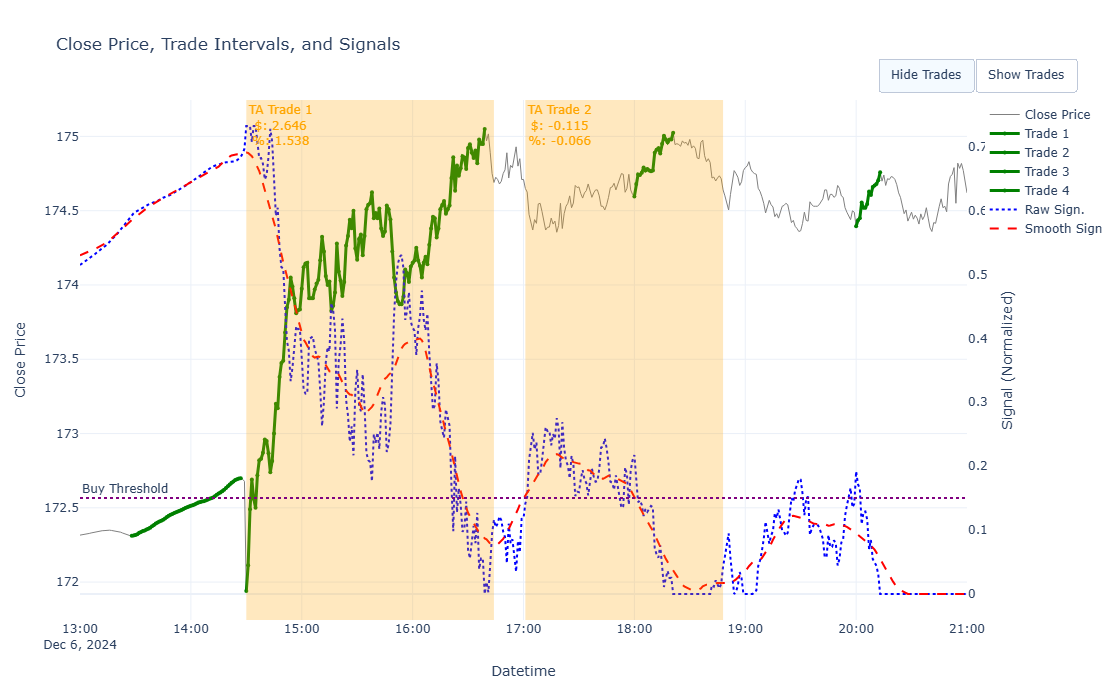

 Daily Performance:
   Final Net Value ($): 2.531
   Buy & Hold Gain ($): 2.636
   Strategy Profit Difference ($): -0.105
   Final Net Return (%): 1.472
   Buy & Hold Return (%): 1.533
   Strategy Improvement (%): -0.061
   Trade Gains ($): [2.646, -0.115]
   Trade Gains (%): [1.538, -0.066]

=== Processing trading day 2024-12-07 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
 no trades found; skipping.

=== Processing trading day 2024-12-09 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


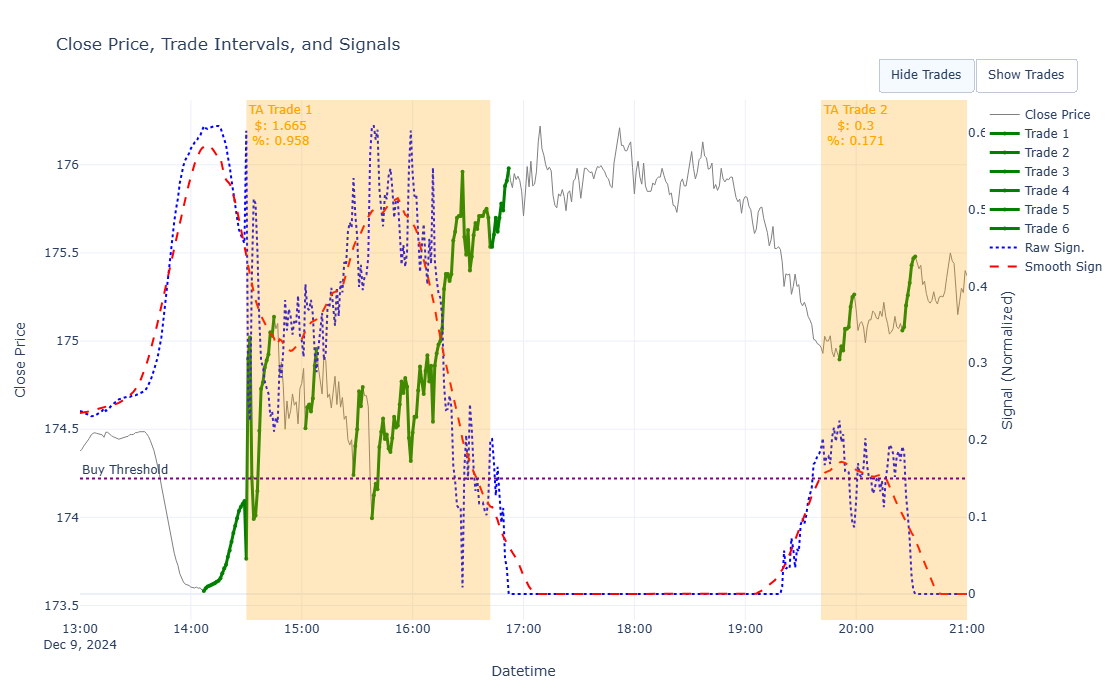

 Daily Performance:
   Final Net Value ($): 1.995
   Buy & Hold Gain ($): 1.53
   Strategy Profit Difference ($): 0.465
   Final Net Return (%): 1.148
   Buy & Hold Return (%): 0.88
   Strategy Improvement (%): 0.267
   Trade Gains ($): [1.665, 0.3]
   Trade Gains (%): [0.958, 0.171]

=== Processing trading day 2024-12-10 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


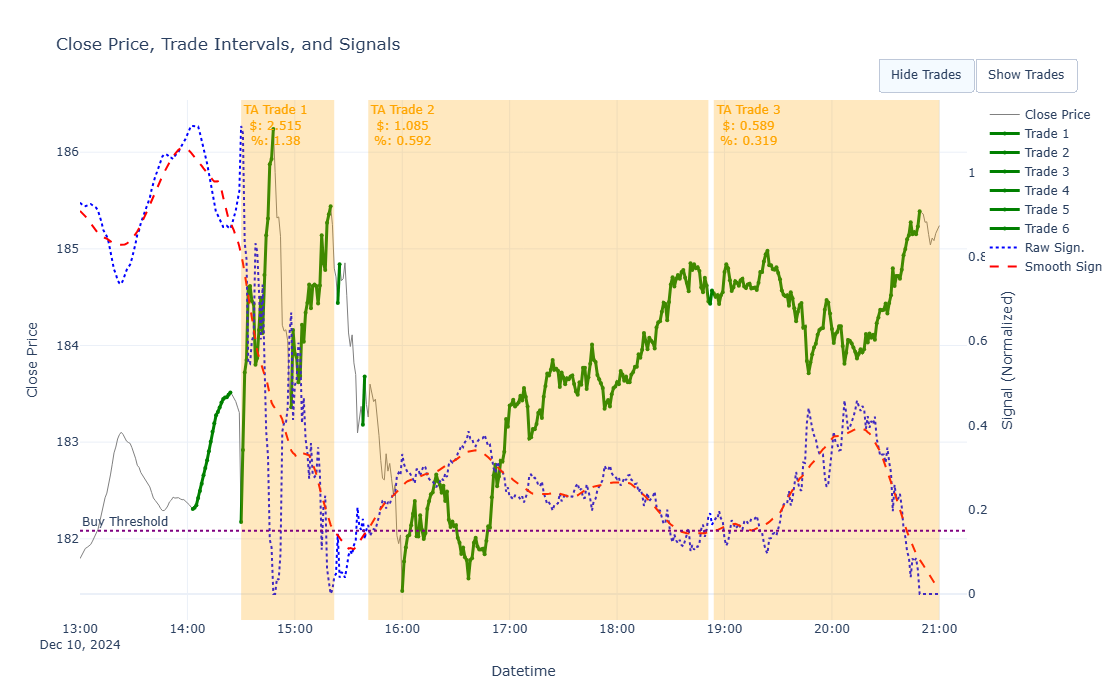

 Daily Performance:
   Final Net Value ($): 4.154
   Buy & Hold Gain ($): 2.92
   Strategy Profit Difference ($): 1.234
   Final Net Return (%): 2.28
   Buy & Hold Return (%): 1.602
   Strategy Improvement (%): 0.677
   Trade Gains ($): [2.515, 1.085, 0.589]
   Trade Gains (%): [1.38, 0.592, 0.319]

=== Processing trading day 2024-12-11 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


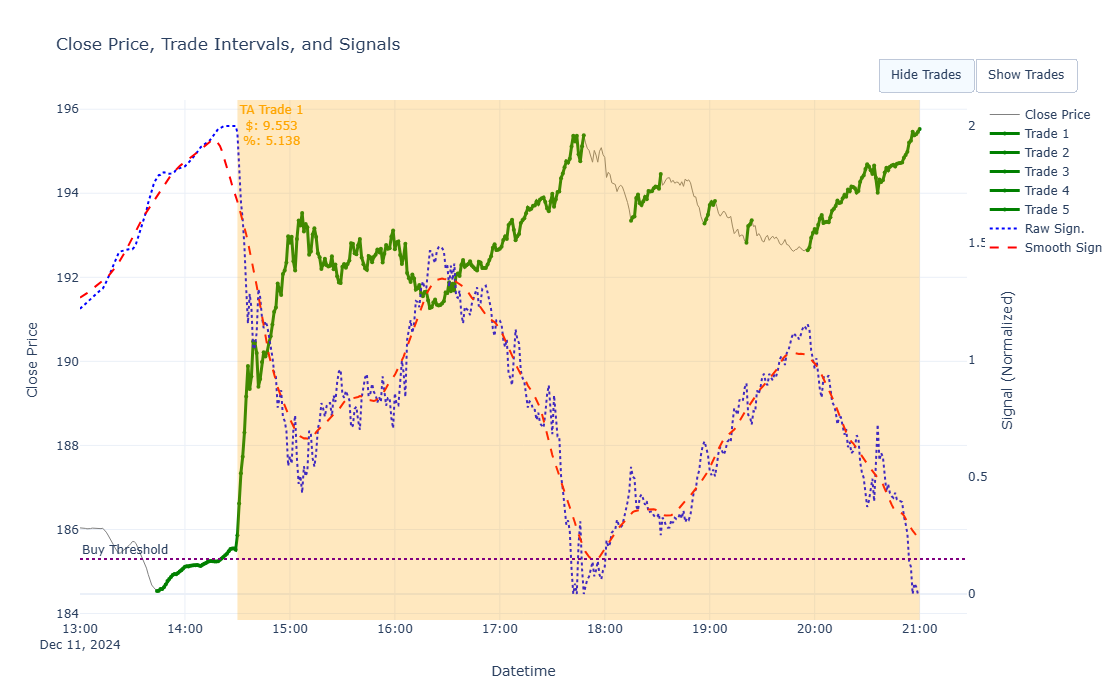

 Daily Performance:
   Final Net Value ($): 9.483
   Buy & Hold Gain ($): 9.483
   Strategy Profit Difference ($): -0.0
   Final Net Return (%): 5.101
   Buy & Hold Return (%): 5.101
   Strategy Improvement (%): -0.0
   Trade Gains ($): [9.553]
   Trade Gains (%): [5.138]

=== Processing trading day 2024-12-12 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


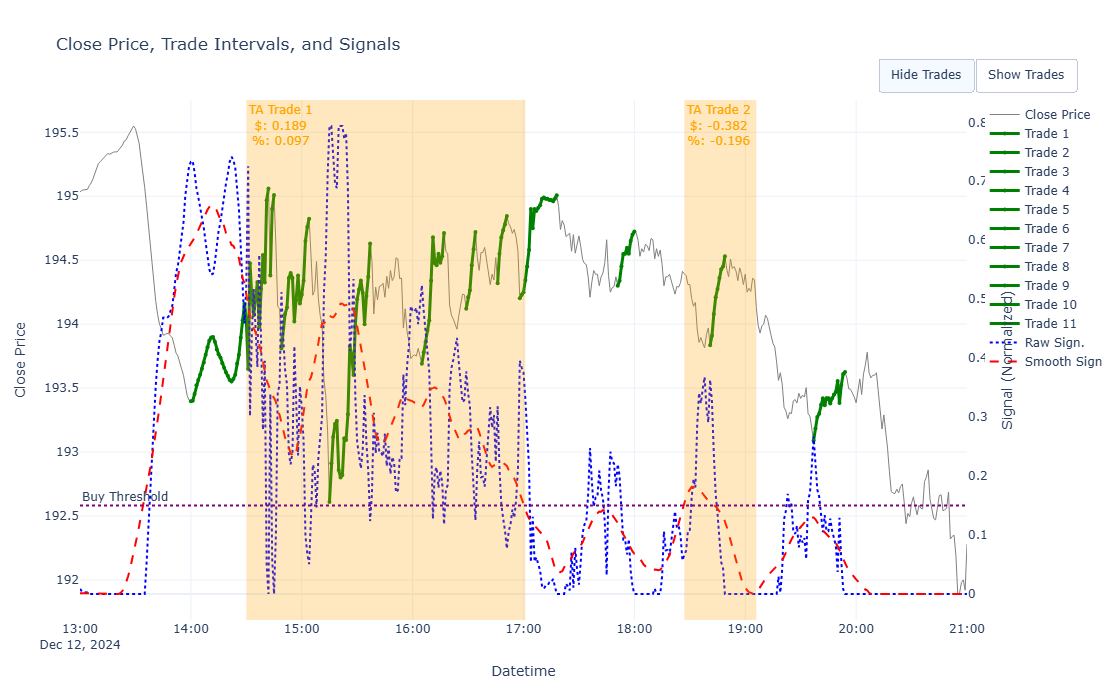

 Daily Performance:
   Final Net Value ($): -0.193
   Buy & Hold Gain ($): -2.236
   Strategy Profit Difference ($): 2.043
   Final Net Return (%): -0.099
   Buy & Hold Return (%): -1.152
   Strategy Improvement (%): 1.052
   Trade Gains ($): [0.189, -0.382]
   Trade Gains (%): [0.097, -0.196]

=== Processing trading day 2024-12-13 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


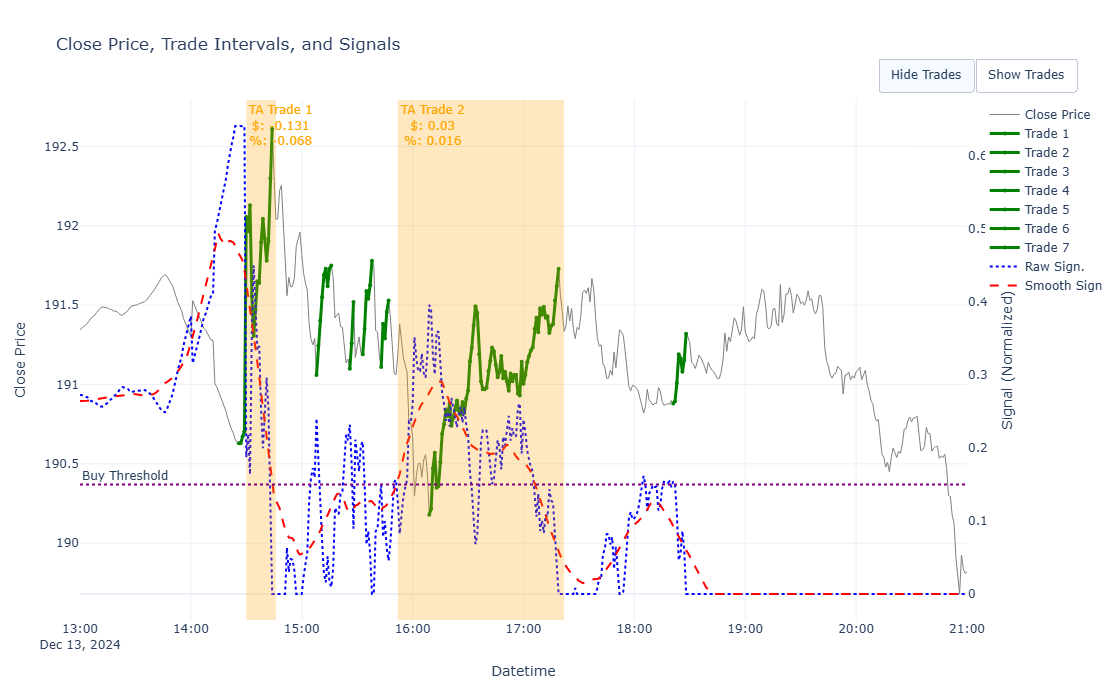

 Daily Performance:
   Final Net Value ($): -0.101
   Buy & Hold Gain ($): -2.36
   Strategy Profit Difference ($): 2.259
   Final Net Return (%): -0.053
   Buy & Hold Return (%): -1.229
   Strategy Improvement (%): 1.176
   Trade Gains ($): [-0.131, 0.03]
   Trade Gains (%): [-0.068, 0.016]

=== Processing trading day 2024-12-14 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
 no trades found; skipping.

=== Processing trading day 2024-12-16 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


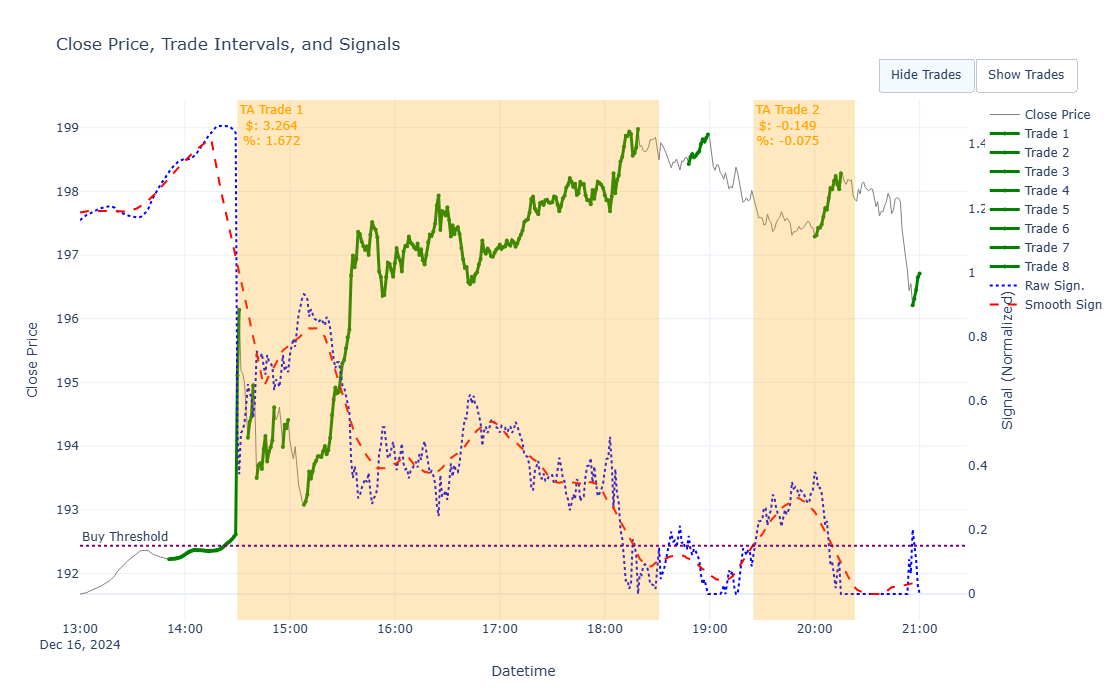

 Daily Performance:
   Final Net Value ($): 3.115
   Buy & Hold Gain ($): 1.423
   Strategy Profit Difference ($): 1.692
   Final Net Return (%): 1.596
   Buy & Hold Return (%): 0.729
   Strategy Improvement (%): 0.867
   Trade Gains ($): [3.264, -0.149]
   Trade Gains (%): [1.672, -0.075]

=== Processing trading day 2024-12-17 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


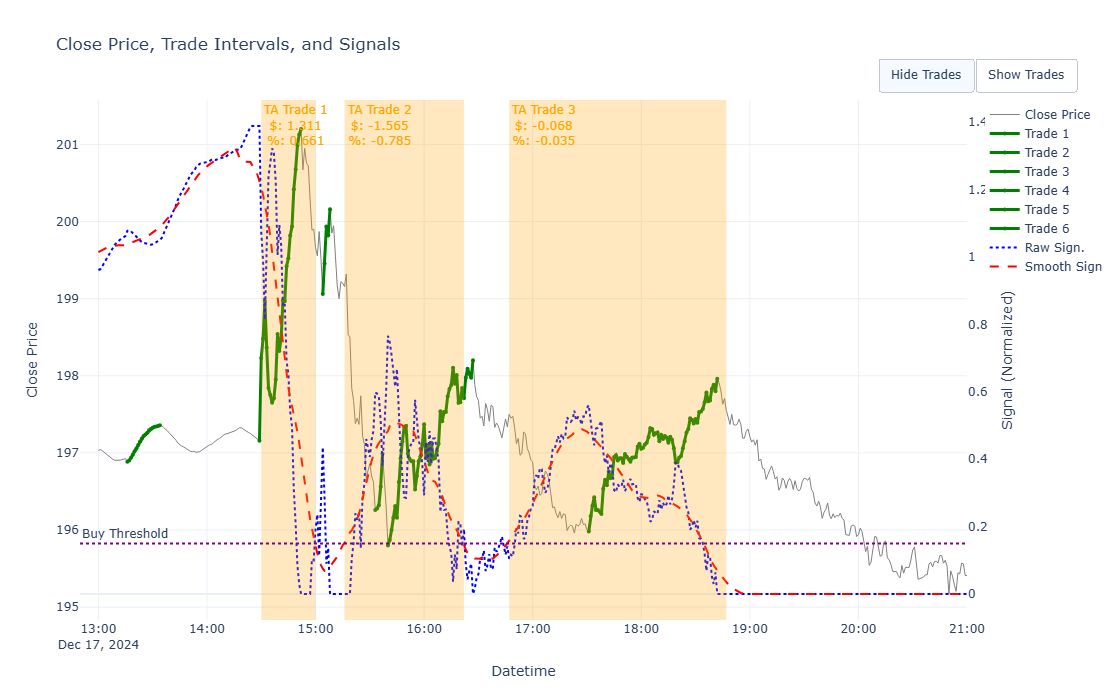

 Daily Performance:
   Final Net Value ($): -0.322
   Buy & Hold Gain ($): -2.938
   Strategy Profit Difference ($): 2.616
   Final Net Return (%): -0.162
   Buy & Hold Return (%): -1.482
   Strategy Improvement (%): 1.319
   Trade Gains ($): [1.311, -1.565, -0.068]
   Trade Gains (%): [0.661, -0.785, -0.035]

=== Processing trading day 2024-12-18 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


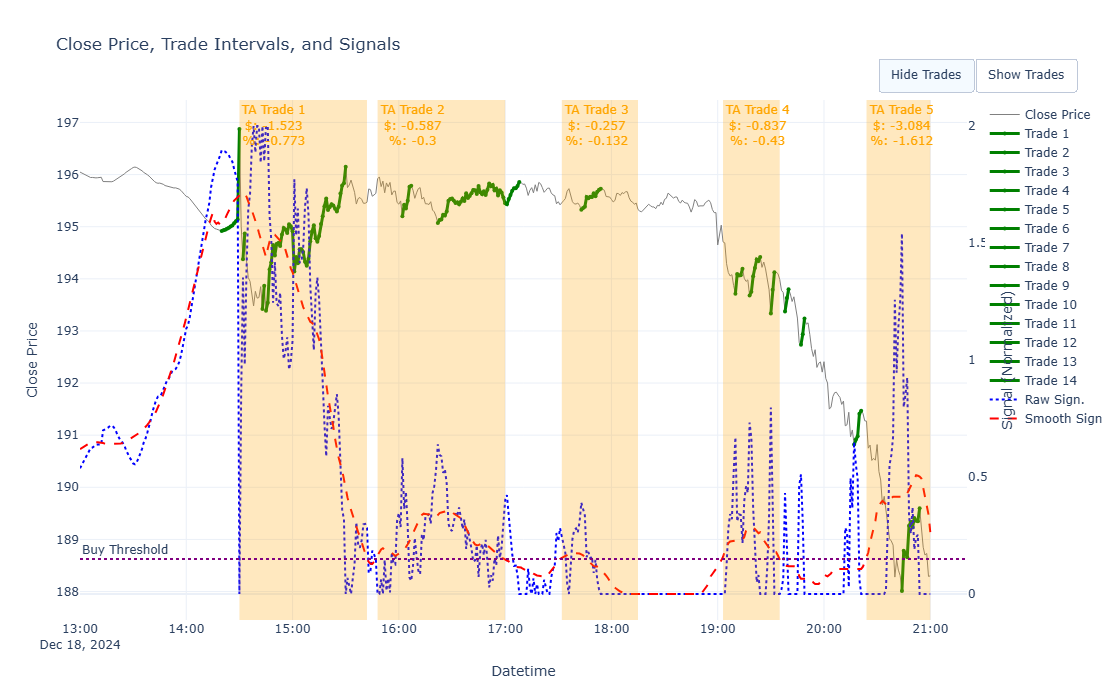

 Daily Performance:
   Final Net Value ($): -6.298
   Buy & Hold Gain ($): -8.701
   Strategy Profit Difference ($): 2.403
   Final Net Return (%): -3.198
   Buy & Hold Return (%): -4.418
   Strategy Improvement (%): 1.22
   Trade Gains ($): [-1.523, -0.587, -0.257, -0.837, -3.084]
   Trade Gains (%): [-0.773, -0.3, -0.132, -0.43, -1.612]

=== Processing trading day 2024-12-19 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


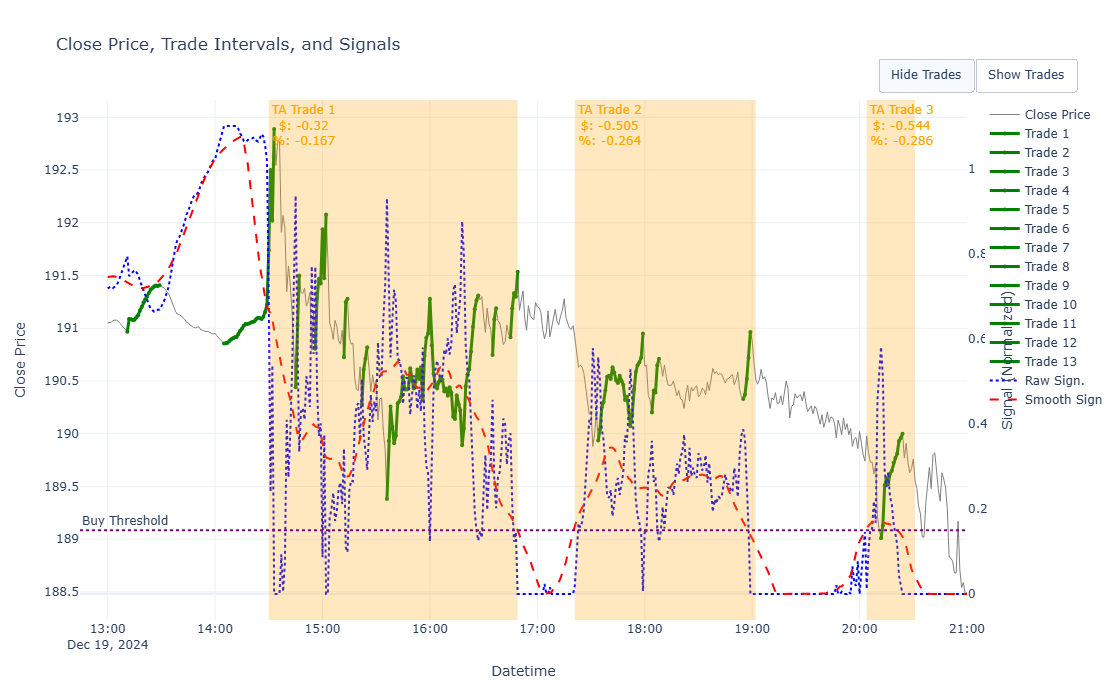

 Daily Performance:
   Final Net Value ($): -1.368
   Buy & Hold Gain ($): -3.374
   Strategy Profit Difference ($): 2.006
   Final Net Return (%): -0.713
   Buy & Hold Return (%): -1.759
   Strategy Improvement (%): 1.046
   Trade Gains ($): [-0.32, -0.505, -0.544]
   Trade Gains (%): [-0.167, -0.264, -0.286]

=== Processing trading day 2024-12-20 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


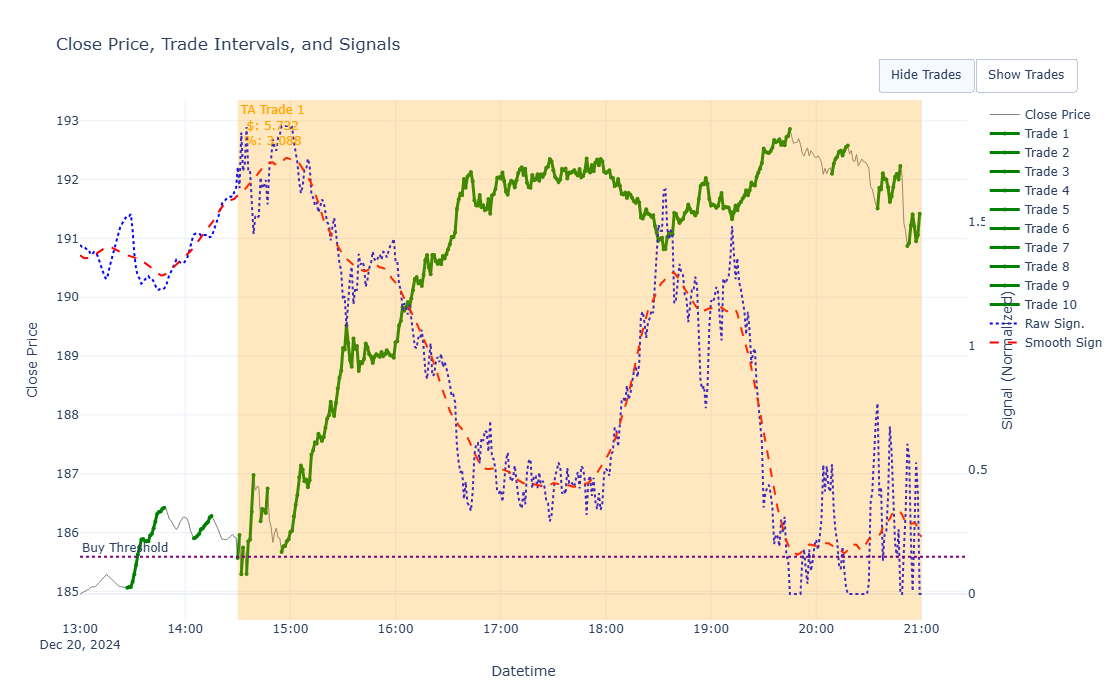

 Daily Performance:
   Final Net Value ($): 5.742
   Buy & Hold Gain ($): 5.742
   Strategy Profit Difference ($): 0.0
   Final Net Return (%): 3.093
   Buy & Hold Return (%): 3.093
   Strategy Improvement (%): 0.0
   Trade Gains ($): [5.732]
   Trade Gains (%): [3.088]

=== Processing trading day 2024-12-21 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
 no trades found; skipping.

=== Processing trading day 2024-12-23 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


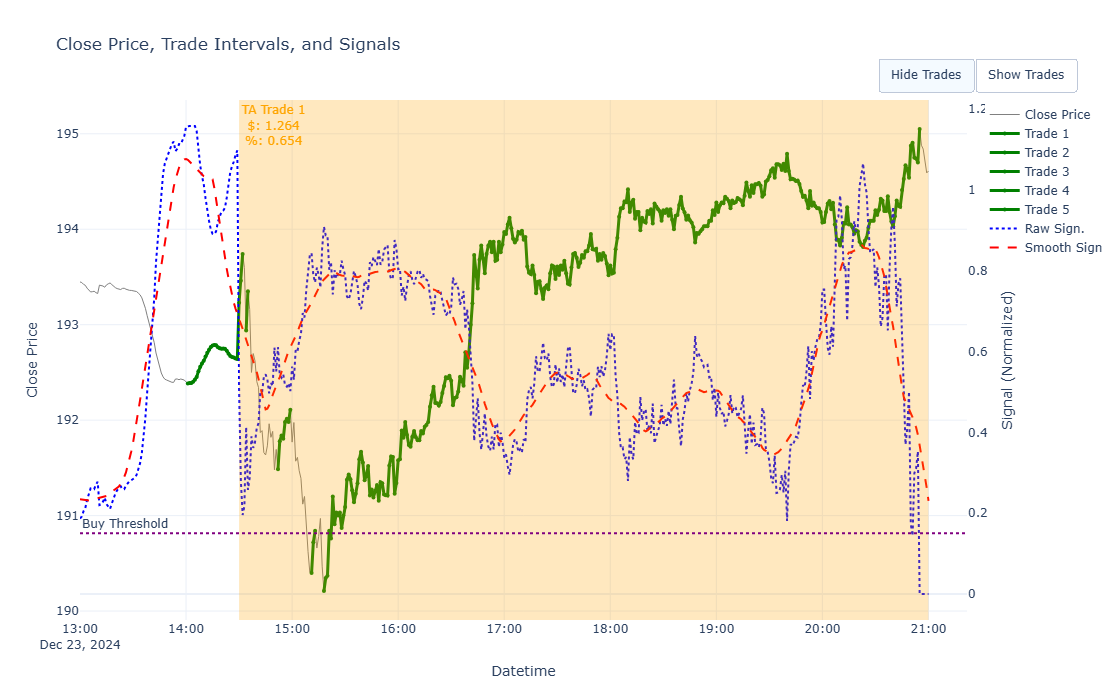

 Daily Performance:
   Final Net Value ($): 1.244
   Buy & Hold Gain ($): 1.244
   Strategy Profit Difference ($): 0.0
   Final Net Return (%): 0.644
   Buy & Hold Return (%): 0.643
   Strategy Improvement (%): 0.0
   Trade Gains ($): [1.264]
   Trade Gains (%): [0.654]

=== Processing trading day 2024-12-24 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


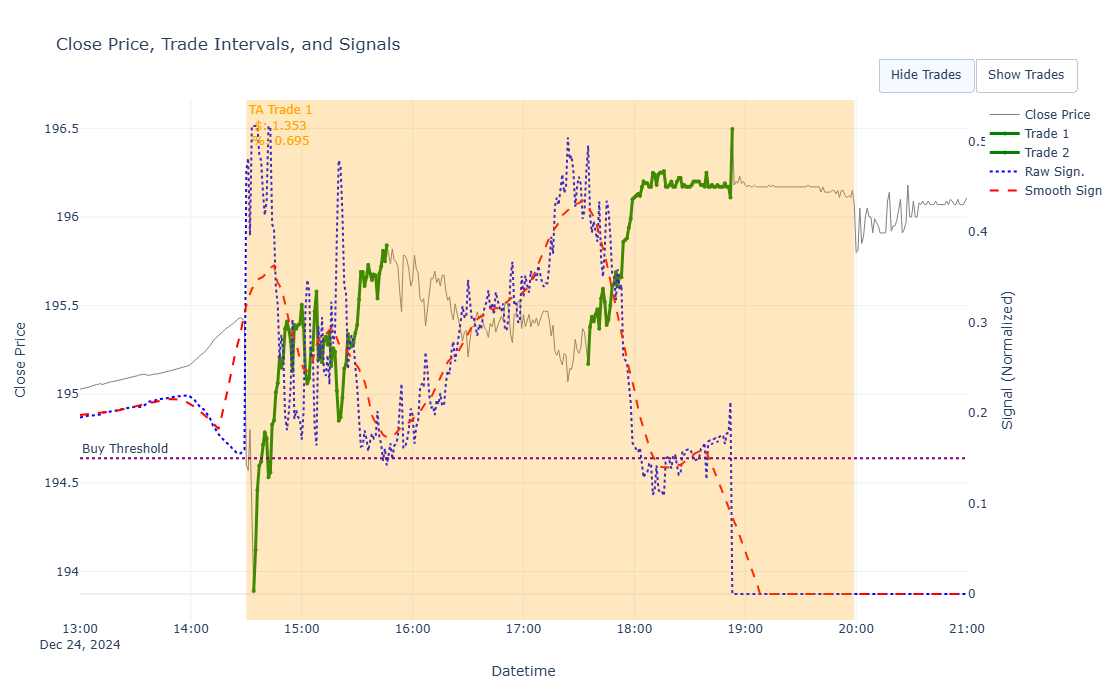

 Daily Performance:
   Final Net Value ($): 1.353
   Buy & Hold Gain ($): 1.373
   Strategy Profit Difference ($): -0.02
   Final Net Return (%): 0.695
   Buy & Hold Return (%): 0.705
   Strategy Improvement (%): -0.01
   Trade Gains ($): [1.353]
   Trade Gains (%): [0.695]

=== Processing trading day 2024-12-26 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


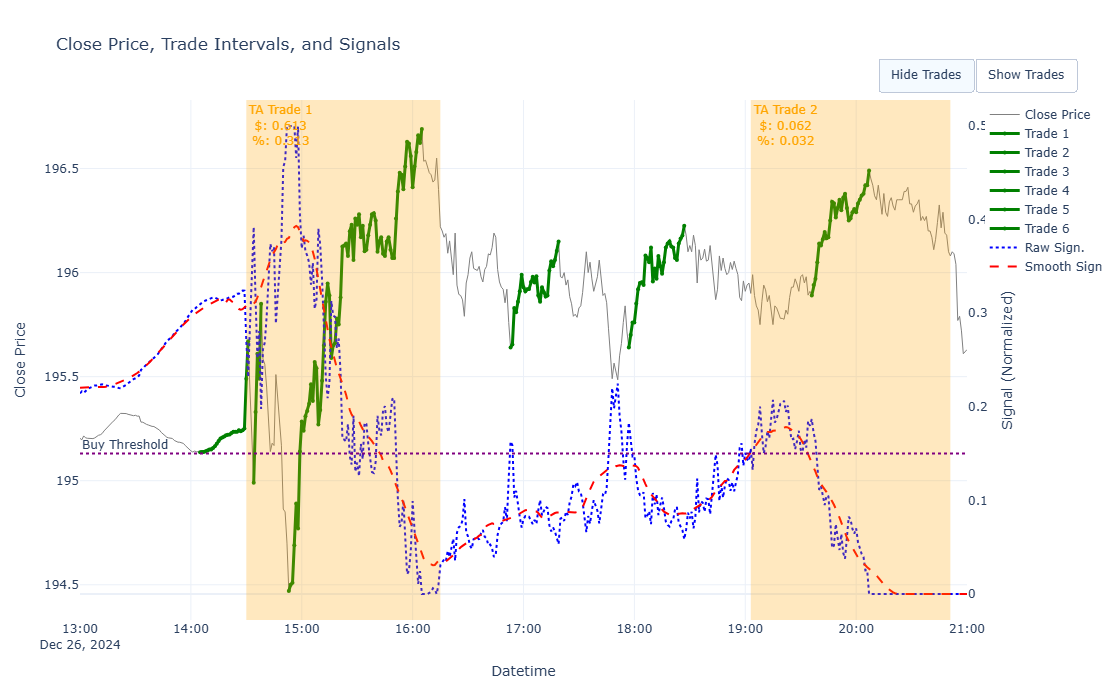

 Daily Performance:
   Final Net Value ($): 0.675
   Buy & Hold Gain ($): 0.013
   Strategy Profit Difference ($): 0.662
   Final Net Return (%): 0.345
   Buy & Hold Return (%): 0.007
   Strategy Improvement (%): 0.339
   Trade Gains ($): [0.613, 0.062]
   Trade Gains (%): [0.313, 0.032]

=== Processing trading day 2024-12-27 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


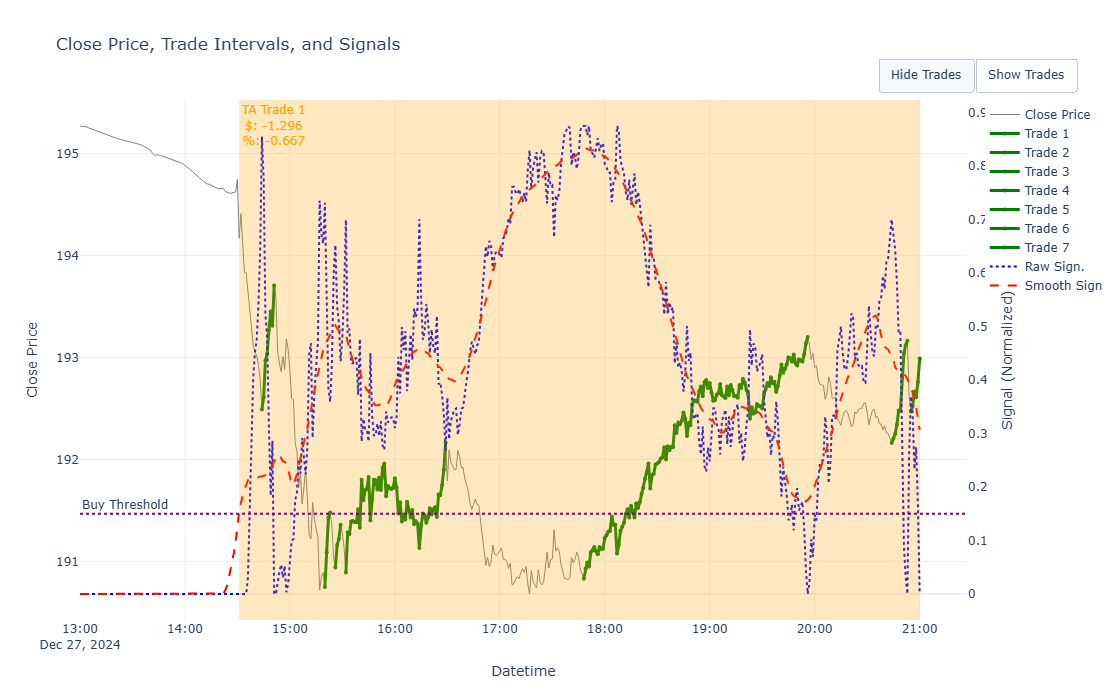

 Daily Performance:
   Final Net Value ($): -1.526
   Buy & Hold Gain ($): -2.101
   Strategy Profit Difference ($): 0.575
   Final Net Return (%): -0.783
   Buy & Hold Return (%): -1.079
   Strategy Improvement (%): 0.295
   Trade Gains ($): [-1.296]
   Trade Gains (%): [-0.667]

=== Processing trading day 2024-12-28 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
 no trades found; skipping.

=== Processing trading day 2024-12-30 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


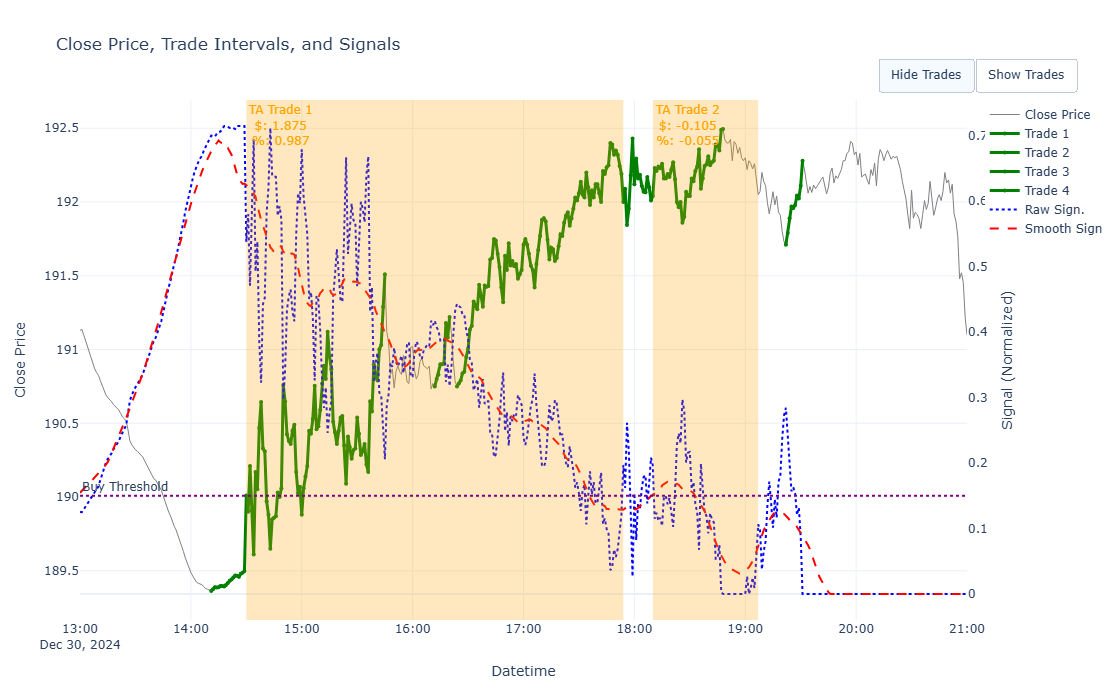

 Daily Performance:
   Final Net Value ($): 1.77
   Buy & Hold Gain ($): 1.096
   Strategy Profit Difference ($): 0.674
   Final Net Return (%): 0.931
   Buy & Hold Return (%): 0.576
   Strategy Improvement (%): 0.355
   Trade Gains ($): [1.875, -0.105]
   Trade Gains (%): [0.987, -0.055]

=== Processing trading day 2024-12-31 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


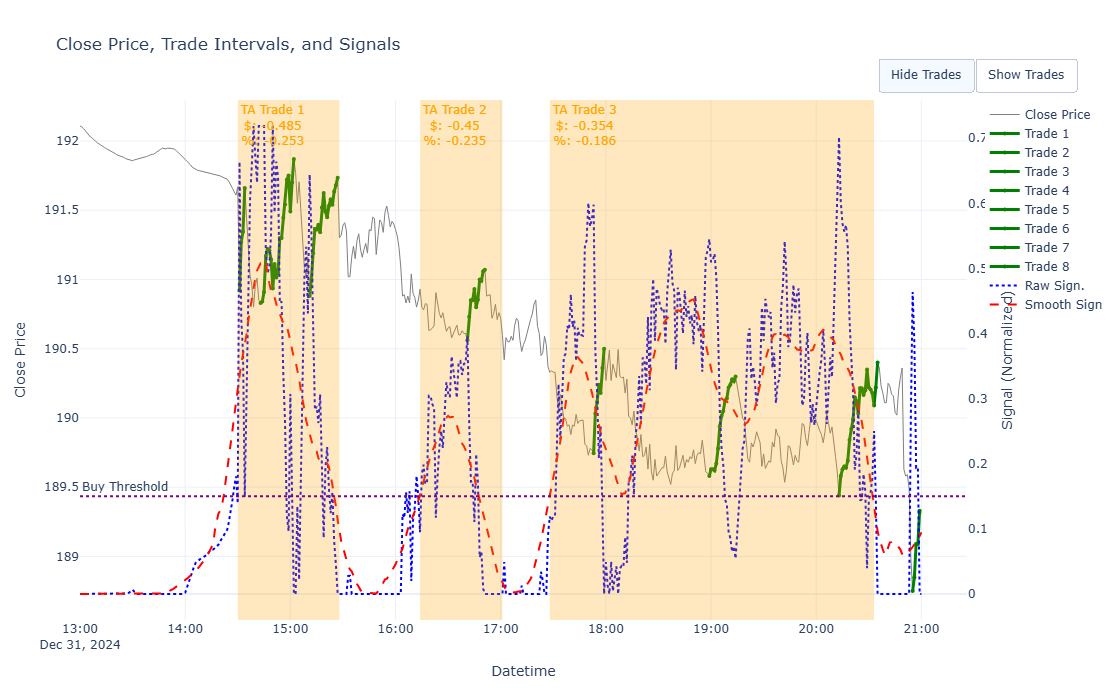

 Daily Performance:
   Final Net Value ($): -1.288
   Buy & Hold Gain ($): -2.454
   Strategy Profit Difference ($): 1.166
   Final Net Return (%): -0.672
   Buy & Hold Return (%): -1.28
   Strategy Improvement (%): 0.608
   Trade Gains ($): [-0.485, -0.45, -0.354]
   Trade Gains (%): [-0.253, -0.235, -0.186]

Final Summary for month 2024-12:
{'Buy & Hold Gain ($)': 4.828,
 'Buy & Hold Return (%)': 3.416,
 'Final Net Return (%)': 13.268,
 'Final Net Value ($)': 23.721,
 'Strategy Improvement (%)': 9.852,
 'Strategy Profit Difference ($)': 18.893,
 'Trade Gains ($)': '47 trades',
 'Trade Gains (%)': '47 trades'}


In [6]:
df_fin = saveDF_checkDAY(
                        df=df,
                        ticker=params.ticker,
                        min_prof_thr=params.min_prof_thr_man, 
                        max_down_prop=params.max_down_prop_man, 
                        gain_tightening_factor=params.gain_tightening_factor_man,
                        smooth_win_sig=params.smooth_win_sig_man, 
                        pre_entry_decay=params.pre_entry_decay_man, 
                        buy_threshold=params.buy_threshold_man, 
                        trailing_stop_thresh=params.trailing_stop_thresh_man,
                        merging_retracement_thr=params.merging_retracement_thr_man, 
                        merging_time_gap_thr=params.merging_time_gap_thr_man,
                        reference_gain=reference_gain,
                        date_to_check=date_to_check
                        )

df_fin